# 🎯 Phase-C ComfortScore model and explanation layer

**Objective**
Create an interpretable venue level ComfortScore from the Phase B features, then generate a simple explanation layer.

- ComfortScore represents structural environmental comfort potential derived from physical and infrastructural conditions.
- It does not measure perceived comfort, individual wellbeing, satisfaction, behaviour, or lived experience.
- The score describes environmental opportunity structures rather than human outcomes.

### C0 Setup

In [1]:
# ============================================================
# C0 Setup, paths, and reproducibility
# ============================================================

import json
import time
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd

try:
    from scipy.stats import spearmanr
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False
    spearmanr = None


def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()


NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# Resolve Phase B outputs from provenance if available
# ------------------------------------------------------------
PHASEB_PROVENANCE_PATH = PROCESSED_DIR / "provenance_phaseB_features.json"

# Default guesses (will be overridden by provenance if it exists)
FEATURES_CSV = PROCESSED_DIR / "venues_features.csv"
FEATURES_GPKG_PATH = PROCESSED_DIR / "venues_features.gpkg"

if PHASEB_PROVENANCE_PATH.exists():
    prov_b = json.loads(PHASEB_PROVENANCE_PATH.read_text(encoding="utf-8"))
    outputs_b = prov_b.get("outputs", {})

    csv_path = outputs_b.get("venues_features_csv")
    gpkg_path = outputs_b.get("venues_features_gpkg")

    if csv_path:
        FEATURES_CSV = Path(csv_path)
    if gpkg_path:
        FEATURES_GPKG_PATH = Path(gpkg_path)

# Variables used later in C5
FEATURES_GPKG = str(FEATURES_GPKG_PATH)
FEATURES_GPKG_PATH_PHASEB = FEATURES_GPKG_PATH

# ------------------------------------------------------------
# Outputs
# ------------------------------------------------------------
SCORED_CSV = RESULTS_DIR / "venues_scored.csv"
DIAGNOSTICS_JSON = RESULTS_DIR / "comfort_model_diagnostics.json"
EXPL_COUNTS_CSV = RESULTS_DIR / "explanation_category_counts.csv"
PROV_JSON = RESULTS_DIR / "provenance_phaseC_model.json"

print("PROJECT_ROOT", PROJECT_ROOT)
print("FEATURES_CSV", FEATURES_CSV)
print("FEATURES_GPKG_PATH", FEATURES_GPKG_PATH)
print("RESULTS_DIR", RESULTS_DIR)

if not FEATURES_CSV.exists():
    raise FileNotFoundError(
        f"Missing features file: {FEATURES_CSV}. Run Phase B first."
    )

if not FEATURES_GPKG_PATH.exists():
    raise FileNotFoundError(
        f"Missing Phase B GeoPackage: {FEATURES_GPKG_PATH}. "
        "Run Phase B first so geometry is available for joining scores."
    )


PROJECT_ROOT /home/sai/test/notebook_test
FEATURES_CSV /home/sai/test/notebook_test/data/processed/venues_features.csv
FEATURES_GPKG_PATH /home/sai/test/notebook_test/data/processed/venues_features.gpkg
RESULTS_DIR /home/sai/test/notebook_test/data/results


In [2]:
from pathlib import Path
import json

# Notebook is in notebooks/, project root is one level up
NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

# Phase B provenance (created by Phase B at the end)
PHASEB_PROVENANCE_PATH = PROCESSED_DIR / "provenance_phaseB_features.json"

if not PHASEB_PROVENANCE_PATH.exists():
    raise FileNotFoundError(
        f"Phase B provenance not found: {PHASEB_PROVENANCE_PATH}\n"
        "Run Phase B first, or check your folders."
    )

prov_b = json.loads(PHASEB_PROVENANCE_PATH.read_text(encoding="utf-8"))

# Pull the exact paths Phase B wrote
FEATURES_CSV_PATH = Path(prov_b["outputs"]["venues_features_csv"])
FEATURES_GPKG_PATH = Path(prov_b["outputs"]["venues_features_gpkg"])

if not FEATURES_GPKG_PATH.exists():
    raise FileNotFoundError(f"Phase B GeoPackage not found at: {FEATURES_GPKG_PATH}")

print("Resolved Phase B outputs:")
print("FEATURES_CSV_PATH =", FEATURES_CSV_PATH)
print("FEATURES_GPKG_PATH =", FEATURES_GPKG_PATH)


Resolved Phase B outputs:
FEATURES_CSV_PATH = /home/sai/test/notebook_test/data/processed/venues_features.csv
FEATURES_GPKG_PATH = /home/sai/test/notebook_test/data/processed/venues_features.gpkg


### C1 Load features and validate

We load the Phase B feature table and enforce numeric ranges.


In [3]:
# ============================================================
# C1 Load features
# ============================================================

t0 = time.time()
df = pd.read_csv(FEATURES_CSV)

required = ["id", "QuietScore", "GreenScore", "CrowdScore", "AccessScore"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"venues_features.csv missing required columns: {missing}")

df["id"] = df["id"].astype(str)

for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# If anything is missing, fill with median of that feature
for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    if df[c].isna().any():
        med = float(df[c].median(skipna=True))
        df[c] = df[c].fillna(med)

# Clip to 0 to 1 for safety
for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    df[c] = df[c].clip(0.0, 1.0)

print("Rows", int(len(df)))
print("Feature summary")
display(df[["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]].describe())
print("Load seconds", round(float(time.time() - t0), 3))


Rows 1211
Feature summary


,QuietScore,GreenScore,CrowdScore,AccessScore
count,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.454123,0.146886,0.740688,0.265483
std,0.136713,0.139144,0.165683,0.224892
min,0.311651,0.000000,0.000000,0.000000
25%,0.378925,0.079298,0.621795,0.200000
50%,0.410497,0.109663,0.766026,0.200000
75%,0.451481,0.157040,0.875801,0.200000
max,0.857143,1.000000,1.000000,1.000000


Load seconds 0.17


### C2 ComfortScore definition

- ComfortScore is a weighted sum of the four components.
- All inputs are already scaled to 0 to 1 in Phase B.

Note:
- Component weights are chosen for interpretability rather than optimisation.
- No ground truth exists for urban comfort potential, making data driven tuning inappropriate.
- Equal or near equal weights prioritise transparency and stability over predictive fit.

In [4]:
# ============================================================
# C2 ComfortScore model (FINAL, consistent with Phase B)
# CrowdScore from Phase B is already calmness (higher is better)
# We keep it as is and expose CrowdCalmScore for transparency
# ============================================================

import numpy as np
import pandas as pd

# Required feature columns
FEATURE_COLS = ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]

# Default weights (must sum to a positive value, do not need to sum to 1)
WEIGHTS = {
    "QuietScore": 0.30,
    "GreenScore": 0.30,
    "CrowdScore": 0.30,   # calmness signal from Phase B
    "AccessScore": 0.10
}

# Defensive checks
missing = [c for c in ["id"] + FEATURE_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Phase C C2 missing required columns in df: {missing}")

# Ensure numeric and clipped to [0, 1]
for c in FEATURE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    if df[c].isna().any():
        df[c] = df[c].fillna(float(df[c].median(skipna=True)))
    df[c] = df[c].clip(0.0, 1.0)

# CrowdScore from Phase B is already higher = better (lower crowd pressure)
df["CrowdCalmScore"] = df["CrowdScore"].astype(float)

def calculate_comfort_score(frame: pd.DataFrame, weights: dict) -> pd.Series:
    s = np.zeros(len(frame), dtype=float)
    wsum = 0.0

    for k, w in weights.items():
        if k not in frame.columns and k != "CrowdScore":
            raise ValueError(f"Missing feature column: {k}")

        w = float(w)
        if not np.isfinite(w):
            raise ValueError(f"Non finite weight for {k}: {w}")
        wsum += w

        if k == "CrowdScore":
            x = frame["CrowdCalmScore"].to_numpy(dtype=float)
        else:
            x = frame[k].to_numpy(dtype=float)

        s += w * x

    if not np.isfinite(wsum) or wsum <= 0:
        raise ValueError("Sum of weights must be positive")

    return pd.Series(s / wsum, index=frame.index)

# Compute score and ranks
df["ComfortScore"] = calculate_comfort_score(df, WEIGHTS)
df["ComfortRank"] = df["ComfortScore"].rank(ascending=False, method="average")

# Percentile where 1.0 means best, 0.0 means worst
df["ComfortPercentile"] = df["ComfortScore"].rank(pct=True, ascending=True)

print("ComfortScore summary")
display(df[["ComfortScore", "ComfortRank", "ComfortPercentile"]].describe())

# Sanity checks for crowd direction
print(
    "Spearman ComfortScore vs CrowdScore (should be positive):",
    float(df[["ComfortScore", "CrowdScore"]].corr(method="spearman").iloc[0, 1])
)
print(
    "Spearman ComfortScore vs CrowdCalmScore (should match above):",
    float(df[["ComfortScore", "CrowdCalmScore"]].corr(method="spearman").iloc[0, 1])
)

print("Weights used:", {k: float(v) for k, v in WEIGHTS.items()})


ComfortScore summary


,ComfortScore,ComfortRank,ComfortPercentile
count,1211.000000,1211.000000,1211.000000
mean,0.429058,606.000000,0.500413
std,0.094837,349.729895,0.288794
min,0.140173,1.000000,0.000826
25%,0.362898,303.500000,0.250619
50%,0.420802,606.000000,0.500413
75%,0.471679,908.500000,0.750206
max,0.829824,1211.000000,1.000000


Spearman ComfortScore vs CrowdScore (should be positive): 0.8139974865900758
Spearman ComfortScore vs CrowdCalmScore (should match above): 0.8139974865900758
Weights used: {'QuietScore': 0.3, 'GreenScore': 0.3, 'CrowdScore': 0.3, 'AccessScore': 0.1}


### C3 Explanation layer

We add a simple category label that is easy to report:
- crowd_low means low crowd pressure signal
- accessibility_high means strong accessibility signal
- mixed means multiple strengths
- other means no single strong pattern


In [5]:
# ============================================================
# C3 Explanation layer (FINAL, consistent with Phase B)
# Uses percentile thresholds to get a useful category mix
# CrowdScore is calmness, so crowd_low uses top percentile of CrowdScore
# ============================================================

import pandas as pd

def _rank_pct(s: pd.Series) -> pd.Series:
    return pd.Series(s).rank(method="average", pct=True)

# Strong signal threshold
# 0.80 means top 20 percent
T_STRONG = 0.80

q_pct = _rank_pct(df["QuietScore"])
g_pct = _rank_pct(df["GreenScore"])
a_pct = _rank_pct(df["AccessScore"])

# CrowdScore is calmness (higher better)
c_calm_pct = _rank_pct(df["CrowdScore"])

def explanation_category_percentiles(i: int) -> str:
    strong = []

    if float(q_pct.iloc[i]) >= T_STRONG:
        strong.append("quiet_high")
    if float(g_pct.iloc[i]) >= T_STRONG:
        strong.append("green_high")
    if float(c_calm_pct.iloc[i]) >= T_STRONG:
        strong.append("crowd_low")
    if float(a_pct.iloc[i]) >= T_STRONG:
        strong.append("accessibility_high")

    if len(strong) == 0:
        return "other"
    if len(strong) == 1:
        return strong[0]
    return "mixed"

df["ExplanationCategory"] = [explanation_category_percentiles(i) for i in range(len(df))]

def explanation_text_percentiles(i: int) -> str:
    parts = []

    if float(q_pct.iloc[i]) >= T_STRONG:
        parts.append("quieter streets")
    if float(g_pct.iloc[i]) >= T_STRONG:
        parts.append("greener surroundings")
    if float(c_calm_pct.iloc[i]) >= T_STRONG:
        parts.append("lower activity pressure")
    if float(a_pct.iloc[i]) >= T_STRONG:
        parts.append("better wheelchair support")

    if not parts:
        return "No single dominant signal. ComfortScore reflects the combined balance of components."
    return "Strong signals include " + ", ".join(parts) + "."

df["ExplanationText"] = [explanation_text_percentiles(i) for i in range(len(df))]

counts = df["ExplanationCategory"].value_counts(dropna=False).reset_index()
counts.columns = ["ExplanationCategory", "Count"]
counts["Share"] = counts["Count"] / float(counts["Count"].sum())

print("Explanation category counts")
display(counts)


Explanation category counts


,ExplanationCategory,Count,Share
0,other,623,0.514451
1,mixed,206,0.170107
2,green_high,112,0.092486
3,accessibility_high,92,0.075970
4,crowd_low,91,0.075145
5,quiet_high,87,0.071841


### C4 Robustness checks

We compare the baseline weights against two alternatives:
- equal weights
- standardised features with baseline weights

We report Spearman correlation and top overlap at 10 percent and 5 percent.


In [6]:
# ============================================================
# C4 Robustness metrics (FINAL, consistent with Phase B)
# Uses the same calculate_comfort_score which uses CrowdCalmScore internally
# ============================================================

import numpy as np
import pandas as pd

def top_overlap(a: pd.Series, b: pd.Series, frac: float) -> float:
    n = int(np.ceil(frac * len(a)))
    ia = set(a.sort_values(ascending=False).head(n).index.tolist())
    ib = set(b.sort_values(ascending=False).head(n).index.tolist())
    if n <= 0:
        return float("nan")
    return float(len(ia.intersection(ib)) / n)

def zscore(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mu = float(s.mean())
    sd = float(s.std(ddof=0))
    if sd <= 0 or (not np.isfinite(sd)):
        return s * 0.0
    return (s - mu) / sd

baseline = df["ComfortScore"].copy()

equal_weights = {k: 1.0 for k in FEATURE_COLS}
score_equal = calculate_comfort_score(df, equal_weights)

df_std = df.copy()
for c in FEATURE_COLS:
    df_std[c] = zscore(df_std[c])

# Keep CrowdCalmScore aligned in the standardised frame too
df_std["CrowdCalmScore"] = df_std["CrowdScore"]

score_std = calculate_comfort_score(df_std, WEIGHTS)

if "SCIPY_OK" in globals() and SCIPY_OK:
    rho_we, _ = spearmanr(baseline.to_numpy(dtype=float), score_equal.to_numpy(dtype=float))
    rho_ws, _ = spearmanr(baseline.to_numpy(dtype=float), score_std.to_numpy(dtype=float))
else:
    rho_we = float(pd.Series(baseline).corr(pd.Series(score_equal), method="spearman"))
    rho_ws = float(pd.Series(baseline).corr(pd.Series(score_std), method="spearman"))

robustness = {
    "spearman_weighted_vs_equal": float(rho_we),
    "top_overlap_10_percent_vs_equal": float(top_overlap(baseline, score_equal, 0.10)),
    "top_overlap_5_percent_vs_equal": float(top_overlap(baseline, score_equal, 0.05)),
    "spearman_weighted_vs_standardised": float(rho_ws),
    "top_overlap_10_percent_vs_standardised": float(top_overlap(baseline, score_std, 0.10)),
    "top_overlap_5_percent_vs_standardised": float(top_overlap(baseline, score_std, 0.05)),
}

print("Robustness metrics")
display(pd.DataFrame([robustness]))


Robustness metrics


,spearman_weighted_vs_equal,top_overlap_10_percent_vs_equal,top_overlap_5_percent_vs_equal,spearman_weighted_vs_standardised,top_overlap_10_percent_vs_standardised,top_overlap_5_percent_vs_standardised
0,0.938908,0.622951,0.590164,0.994963,0.967213,0.967213


### C5 Save scored outputs

We write the scored table and the diagnostic summaries used by later chapters.


In [7]:
# ============================================================
# C5 Write outputs 
# Writes CSV + diagnostics + provenance + scored GeoPackage for mapping
# ============================================================

import json
import time
import geopandas as gpd
from pathlib import Path

t1 = time.time()

# CrowdCalmScore is the crowd signal used in the model
df["CrowdCalmScore"] = df["CrowdScore"]

# Columns to write
out_cols = []
for c in ["id", "name"]:
    if c in df.columns:
        out_cols.append(c)

out_cols += FEATURE_COLS
out_cols += ["CrowdCalmScore"]
out_cols += ["ComfortScore", "ComfortRank", "ComfortPercentile", "ExplanationCategory", "ExplanationText"]

df_out = df[out_cols].copy()

# Ensure stable join key type for all outputs
if "id" in df_out.columns:
    df_out["id"] = df_out["id"].astype(str)

# Write scored CSV
df_out.to_csv(SCORED_CSV, index=False)
print("Saved", SCORED_CSV)

# Write explanation counts CSV
counts.to_csv(EXPL_COUNTS_CSV, index=False)
print("Saved", EXPL_COUNTS_CSV)

# ------------------------------------------------------------
# Save scored GeoPackage by joining scores back to Phase B geometry
# ------------------------------------------------------------
SCORED_GPKG = RESULTS_DIR / "venues_scored.gpkg"

# Resolve Phase B GeoPackage path robustly
if "FEATURES_GPKG" in globals():
    phaseb_gpkg_path = FEATURES_GPKG
elif "FEATURES_GPKG_PATH" in globals():
    phaseb_gpkg_path = FEATURES_GPKG_PATH
elif "FEATURES_GPKG_PATH_PHASEB" in globals():
    phaseb_gpkg_path = FEATURES_GPKG_PATH_PHASEB
else:
    raise NameError("Missing Phase B GeoPackage path. Expected FEATURES_GPKG or FEATURES_GPKG_PATH.")

phaseb_gpkg_path = Path(phaseb_gpkg_path)
if not phaseb_gpkg_path.exists():
    raise FileNotFoundError(f"Phase B GeoPackage not found at: {phaseb_gpkg_path}")

# Read Phase B geometry
gdf_feat = gpd.read_file(phaseb_gpkg_path)
if "id" not in gdf_feat.columns:
    raise KeyError("Phase B GeoPackage must contain 'id' column to join scores back to geometry.")

# Ensure join key type matches
gdf_feat["id"] = gdf_feat["id"].astype(str)

# Join scores onto geometry
gdf_scored = gdf_feat.merge(df_out, on="id", how="left")

# Sanity check: ensure merge succeeded for all rows
if "ComfortScore" not in gdf_scored.columns:
    raise KeyError("ComfortScore missing after merge. Check df_out columns.")
n_missing = int(gdf_scored["ComfortScore"].isna().sum())
if n_missing > 0:
    raise ValueError(
        f"Join produced {n_missing} missing ComfortScore values. "
        "This indicates id mismatch between Phase B and Phase C."
    )

# Write scored GeoPackage
gdf_scored.to_file(SCORED_GPKG, layer="venues_scored", driver="GPKG")
print("Saved", SCORED_GPKG)

# ------------------------------------------------------------
# Diagnostics
# ------------------------------------------------------------
diagnostics = {
    "created_at_utc": now_utc_iso(),
    "weights": {k: float(v) for k, v in WEIGHTS.items()},
    "feature_columns": FEATURE_COLS,
    "crowd_feature_used_in_model": "CrowdCalmScore equals CrowdScore from Phase B",
    "n_venues": int(len(df)),
    "robustness": robustness,
    "component_spearman_with_comfort": {
        "QuietScore": float(df[["ComfortScore", "QuietScore"]].corr(method="spearman").iloc[0, 1]),
        "GreenScore": float(df[["ComfortScore", "GreenScore"]].corr(method="spearman").iloc[0, 1]),
        "CrowdScore": float(df[["ComfortScore", "CrowdScore"]].corr(method="spearman").iloc[0, 1]),
        "AccessScore": float(df[["ComfortScore", "AccessScore"]].corr(method="spearman").iloc[0, 1]),
    },
    "explanations": {
        "strong_threshold_percentile": float(T_STRONG),
        "notes": "crowd_low uses top percentile of CrowdScore because CrowdScore is calmness in Phase B."
    },
}

DIAGNOSTICS_JSON.write_text(json.dumps(diagnostics, indent=2), encoding="utf-8")
print("Saved", DIAGNOSTICS_JSON)

# ------------------------------------------------------------
# Provenance
# ------------------------------------------------------------
prov = {
    "created_at_utc": now_utc_iso(),
    "phase": "C",
    "inputs": {
        "venues_features_csv": str(FEATURES_CSV),
        "venues_features_gpkg": str(phaseb_gpkg_path),
    },
    "outputs": {
        "venues_scored_csv": str(SCORED_CSV),
        "venues_scored_gpkg": str(SCORED_GPKG),
        "comfort_model_diagnostics_json": str(DIAGNOSTICS_JSON),
        "explanation_category_counts_csv": str(EXPL_COUNTS_CSV),
        "provenance_phaseC_model_json": str(PROV_JSON),
    },
    "runtime_s": float(time.time() - t1),
}

PROV_JSON.write_text(json.dumps(prov, indent=2), encoding="utf-8")
print("Saved", PROV_JSON)


Saved /home/sai/test/notebook_test/data/results/venues_scored.csv
Saved /home/sai/test/notebook_test/data/results/explanation_category_counts.csv
Saved /home/sai/test/notebook_test/data/results/venues_scored.gpkg
Saved /home/sai/test/notebook_test/data/results/comfort_model_diagnostics.json
Saved /home/sai/test/notebook_test/data/results/provenance_phaseC_model.json


### C6 Quick inspection

We print a compact summary so you can sanity check before moving on.


Rows 1211
ComfortScore summary


,ComfortScore
count,1211.000000
mean,0.429058
std,0.094837
min,0.140173
25%,0.362898
50%,0.420802
75%,0.471679
max,0.829824


Top venues


,id,name,QuietScore,GreenScore,CrowdScore,AccessScore,CrowdCalmScore,ComfortScore,ComfortRank,ComfortPercentile,ExplanationCategory,ExplanationText
19,336347045,Wagon Cafe,0.857143,0.915988,0.926282,0.2,0.926282,0.829824,1.0,1.000000,mixed,"Strong signals include quieter streets, greene..."
1113,859483943,Village Cafe,0.857143,0.883490,0.926282,0.2,0.926282,0.820075,2.0,0.999174,mixed,"Strong signals include quieter streets, greene..."
624,27426199,Cecil Sharp House,0.458655,0.877299,0.918269,1.0,0.918269,0.776267,3.0,0.998348,mixed,"Strong signals include greener surroundings, l..."
1164,1106478045,sis&sibs,0.857143,0.667296,0.958333,0.2,0.958333,0.764832,4.0,0.997523,mixed,"Strong signals include quieter streets, greene..."
1154,1051336498,Alexandra Resource Centre,0.857143,0.655676,0.913462,0.2,0.913462,0.747884,5.0,0.996697,mixed,"Strong signals include quieter streets, greene..."
116,831257535,Royal Cafe & Sandwhich bar,0.857143,0.656238,0.883013,0.2,0.883013,0.738918,6.0,0.995871,mixed,"Strong signals include quieter streets, greene..."
612,23164245,Goldington Crescent Gardens,0.477827,0.907737,0.887821,0.2,0.887821,0.702015,7.0,0.995045,mixed,"Strong signals include quieter streets, greene..."
243,3855655369,Tobia Cafe,0.460958,0.923882,0.884615,0.2,0.884615,0.700837,8.0,0.994220,green_high,Strong signals include greener surroundings.
855,179438230,Aubert Court Community Centre,0.606215,0.672404,0.940705,0.2,0.940705,0.685797,9.0,0.993394,mixed,"Strong signals include quieter streets, greene..."
758,85719814,Queen's Crescent Library,0.857143,0.177412,0.913462,1.0,0.913462,0.684405,10.0,0.992568,mixed,"Strong signals include quieter streets, lower ..."


Bottom venues


,id,name,QuietScore,GreenScore,CrowdScore,AccessScore,CrowdCalmScore,ComfortScore,ComfortRank,ComfortPercentile,ExplanationCategory,ExplanationText
229,3687948888,Timber Yard,0.395401,0.071841,0.000000,0.0,0.000000,0.140173,1211.0,0.000826,other,No single dominant signal. ComfortScore reflec...
508,11964292769,WatchHouse,0.395435,0.071841,0.000000,0.2,0.000000,0.160183,1210.0,0.001652,other,No single dominant signal. ComfortScore reflec...
87,603113483,La Bottega,0.391634,0.064399,0.097756,0.2,0.097756,0.186137,1209.0,0.002477,other,No single dominant signal. ComfortScore reflec...
64,401529157,Snack Bar & Café,0.385626,0.107629,0.134615,0.0,0.134615,0.188361,1208.0,0.003303,other,No single dominant signal. ComfortScore reflec...
314,5169583425,Covent Garden Community Centre,0.371255,0.053658,0.144231,0.2,0.144231,0.190743,1207.0,0.004129,other,No single dominant signal. ComfortScore reflec...
693,42018705,Phoenix Garden,0.371446,0.059160,0.158654,0.2,0.158654,0.196778,1206.0,0.004955,other,No single dominant signal. ComfortScore reflec...
9,311877305,Costa,0.378242,0.053305,0.187500,0.2,0.187500,0.205714,1205.0,0.005780,other,No single dominant signal. ComfortScore reflec...
824,153261285,Fernandez & Wells,0.368981,0.074231,0.197115,0.2,0.197115,0.212098,1204.0,0.006606,other,No single dominant signal. ComfortScore reflec...
499,11607899738,NOW Trending,0.365797,0.076408,0.206731,0.2,0.206731,0.214681,1203.0,0.007432,other,No single dominant signal. ComfortScore reflec...
498,11607899737,The NOW Building,0.368098,0.080183,0.221154,0.2,0.221154,0.220830,1202.0,0.008258,other,No single dominant signal. ComfortScore reflec...


Robustness


,spearman_weighted_vs_equal,top_overlap_10_percent_vs_equal,top_overlap_5_percent_vs_equal,spearman_weighted_vs_standardised,top_overlap_10_percent_vs_standardised,top_overlap_5_percent_vs_standardised
0,0.938908,0.622951,0.590164,0.994963,0.967213,0.967213


Saved: Chapters/ch4_fig/feature_distributions_hist.png


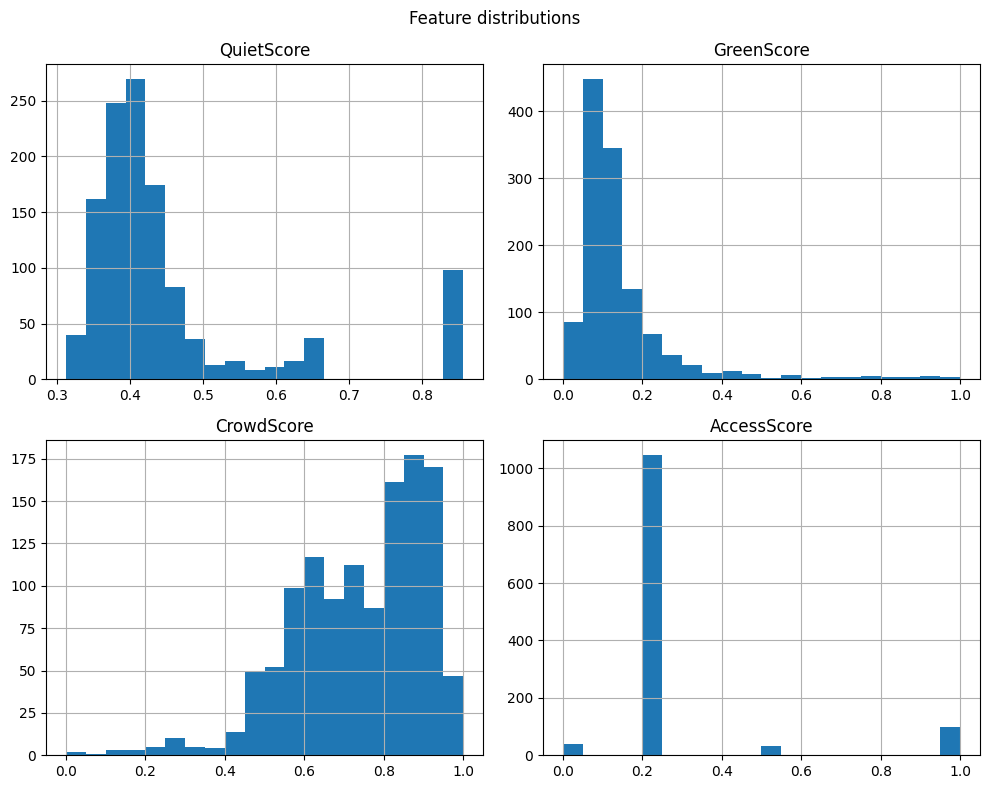

Saved: Chapters/ch4_fig/correlation_spearman_matrix.png


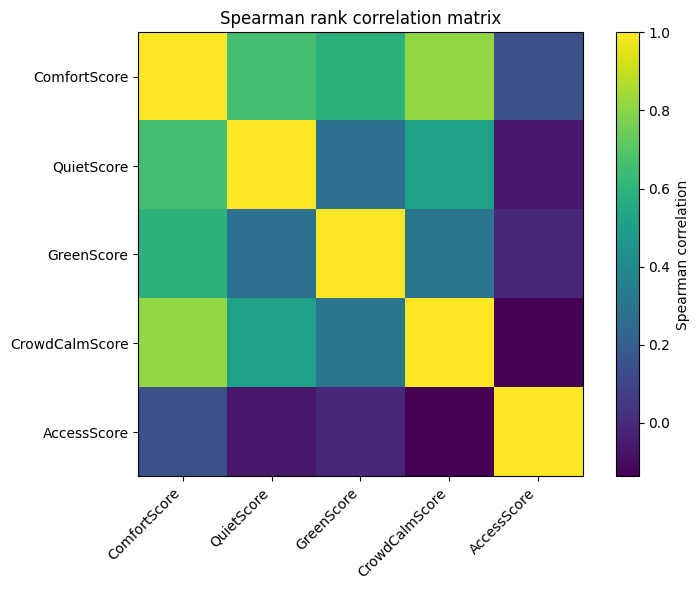

Saved: Chapters/ch4_fig/robustness_metrics_bar.png


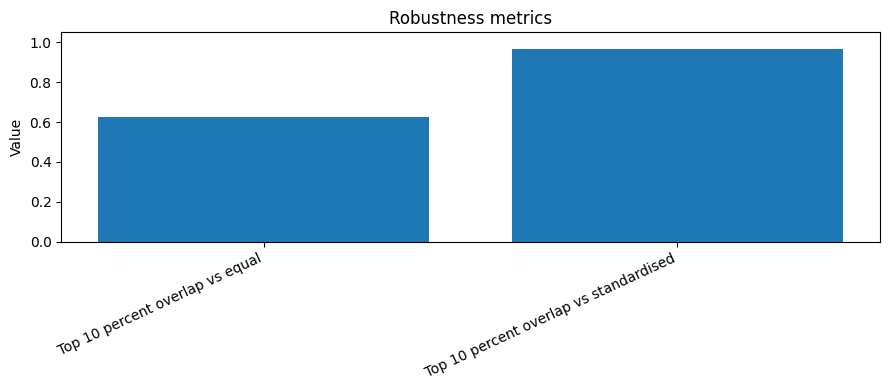

Saved: Chapters/ch4_fig/explanation_category_bar.png


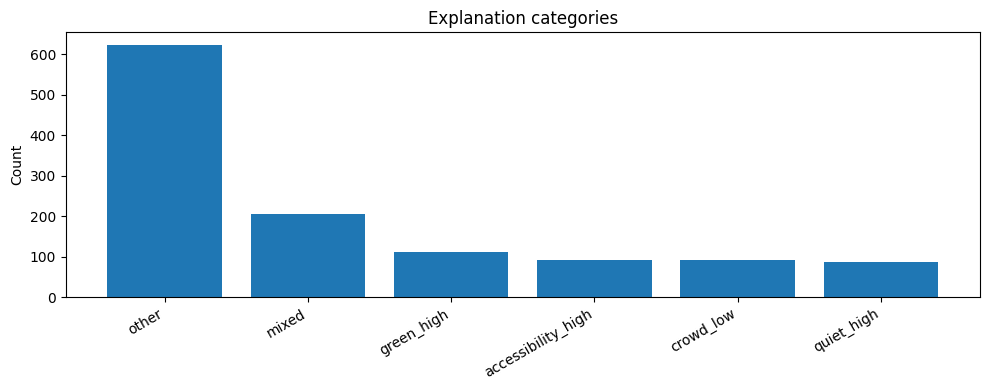

Saved: Chapters/ch4_fig/comfortscore_spatial_scatter.png


<Figure size 700x700 with 0 Axes>

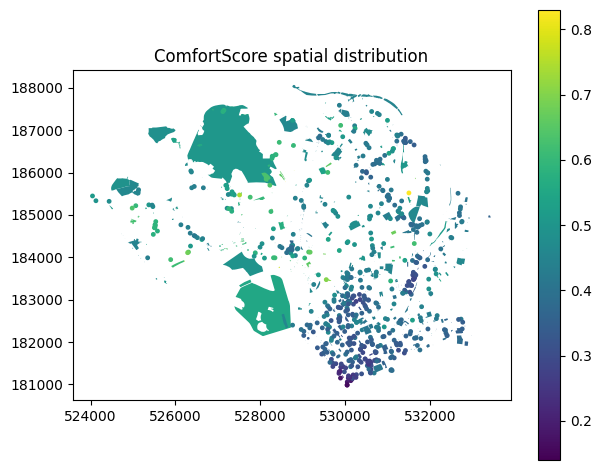

Saved: Chapters/ch4_fig/comfortscore_top_bottom_10pct.png


<Figure size 700x700 with 0 Axes>

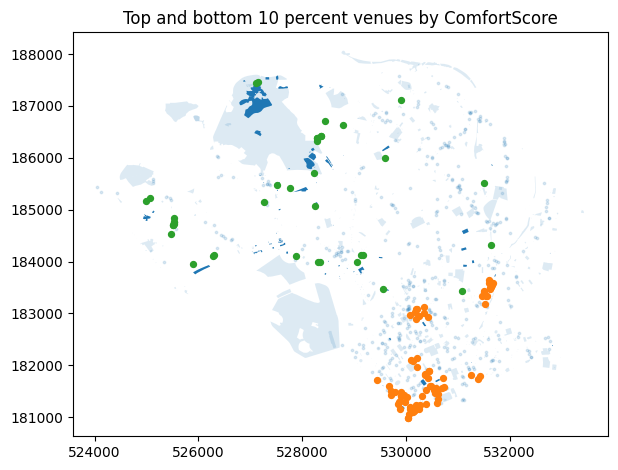

In [8]:
# ============================================================
# C6 Quick summary + export Chapter 4 figures (reproducible)
# ============================================================

import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Quick summary (keep this)
# -----------------------------
print("Rows", int(len(df_out)))
print("ComfortScore summary")
display(df_out[["ComfortScore"]].describe())

print("Top venues")
display(df_out.sort_values("ComfortScore", ascending=False).head(10))

print("Bottom venues")
display(df_out.sort_values("ComfortScore", ascending=True).head(10))

print("Robustness")
display(pd.DataFrame([robustness]))

# -----------------------------
# Figure export directory
# -----------------------------
CH4_FIG_DIR = Path("Chapters/ch4_fig")
CH4_FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load from disk so it is reproducible
df_scored = pd.read_csv(SCORED_CSV)
if "id" in df_scored.columns:
    df_scored["id"] = df_scored["id"].astype(str)

SCORED_GPKG = RESULTS_DIR / "venues_scored.gpkg"
gdf_scored = None
if SCORED_GPKG.exists():
    gdf_scored = gpd.read_file(SCORED_GPKG, layer="venues_scored")
    if "id" in gdf_scored.columns:
        gdf_scored["id"] = gdf_scored["id"].astype(str)
else:
    print("Note: venues_scored.gpkg not found, spatial plots will be skipped:", SCORED_GPKG)

# 1 Feature distributions histogram
cols_hist = [c for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"] if c in df_scored.columns]
if len(cols_hist) > 0:
    df_scored[cols_hist].hist(bins=20, figsize=(10, 8))
    plt.suptitle("Feature distributions")
    plt.tight_layout()
    out_png = CH4_FIG_DIR / "feature_distributions_hist.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping feature distributions: expected columns not found")

# 2 Spearman correlation matrix plot
cols_corr = ["ComfortScore", "QuietScore", "GreenScore", "CrowdCalmScore", "AccessScore"]
use_cols = [c for c in cols_corr if c in df_scored.columns]
if len(use_cols) >= 2:
    corr = df_scored[use_cols].corr(method="spearman")

    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values)
    plt.xticks(range(len(use_cols)), use_cols, rotation=45, ha="right")
    plt.yticks(range(len(use_cols)), use_cols)
    plt.colorbar(label="Spearman correlation")
    plt.title("Spearman rank correlation matrix")
    plt.tight_layout()

    out_png = CH4_FIG_DIR / "correlation_spearman_matrix.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping Spearman matrix: not enough columns found")

# 3 Robustness metrics bar plot from diagnostics JSON
diag_path = DIAGNOSTICS_JSON if "DIAGNOSTICS_JSON" in globals() else (RESULTS_DIR / "comfort_model_diagnostics.json")
diag_path = Path(diag_path)

if diag_path.exists():
    diagnostics = json.loads(diag_path.read_text(encoding="utf-8"))
    rb = diagnostics.get("robustness", {})

    pairs = [
        ("Spearman baseline vs equal", rb.get("spearman_baseline_vs_equal")),
        ("Spearman baseline vs standardised", rb.get("spearman_baseline_vs_standardised")),
        ("Top 10 percent overlap vs equal", rb.get("top_overlap_10_percent_vs_equal")),
        ("Top 10 percent overlap vs standardised", rb.get("top_overlap_10_percent_vs_standardised")),
    ]

    labels = [p[0] for p in pairs if p[1] is not None]
    values = [p[1] for p in pairs if p[1] is not None]

    if len(values) == 0:
        print("Skipping robustness plot: robustness keys not found inside diagnostics['robustness']")
    else:
        plt.figure(figsize=(9, 4))
        plt.bar(labels, values)
        plt.xticks(rotation=25, ha="right")
        plt.ylim(0, 1.05)
        plt.ylabel("Value")
        plt.title("Robustness metrics")

        out_png = CH4_FIG_DIR / "robustness_metrics_bar.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        print("Saved:", out_png)
        plt.show()
else:
    print("Skipping robustness plot: diagnostics JSON not found at", diag_path)

# 4 Explanation category bar plot
if "ExplanationCategory" in df_scored.columns:
    expl = df_scored["ExplanationCategory"].fillna("missing").value_counts().sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    plt.bar(expl.index.astype(str), expl.values)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.title("Explanation categories")

    out_png = CH4_FIG_DIR / "explanation_category_bar.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping explanation plot: ExplanationCategory not found")

# 5 Spatial scatter coloured by ComfortScore
if gdf_scored is not None and "ComfortScore" in gdf_scored.columns:
    plt.figure(figsize=(7, 7))
    gdf_scored.plot(column="ComfortScore", legend=True, markersize=6)
    plt.title("ComfortScore spatial distribution")

    out_png = CH4_FIG_DIR / "comfortscore_spatial_scatter.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping spatial scatter: geometry or ComfortScore missing")

# 6 Top and bottom 10 percent map
if gdf_scored is not None and "ComfortPercentile" in gdf_scored.columns:
    top = gdf_scored[gdf_scored["ComfortPercentile"] >= 0.90].copy()
    bot = gdf_scored[gdf_scored["ComfortPercentile"] <= 0.10].copy()

    plt.figure(figsize=(7, 7))
    base = gdf_scored.plot(markersize=3, alpha=0.15)
    if len(bot) > 0:
        bot.plot(ax=base, markersize=18)
    if len(top) > 0:
        top.plot(ax=base, markersize=18)
    plt.title("Top and bottom 10 percent venues by ComfortScore")

    out_png = CH4_FIG_DIR / "comfortscore_top_bottom_10pct.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping top bottom plot: geometry or ComfortPercentile missing")
